# Time series forecasting with ARIMA

This is an example of a time series forecast using ARIMA, explained step by step.

In [78]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [79]:
url = 'https://raw.githubusercontent.com/Sampayob/Time-Series-ARIMA/master/avocado.csv'
df = pd.read_csv(url)
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


**Date range**

In [80]:
avg_price = df[['Date','AveragePrice']]
avg_price['Date'].min(),avg_price['Date'].max()

('2015-01-04', '2018-03-25')

I think it is interesting to forecast the average price so let's begin.

## Data wrangling

**Missings**

In [81]:
avg_price.isnull().sum()

Date            0
AveragePrice    0
dtype: int64

**Indexing Date**

In [82]:
avg_price.groupby('Date')['AveragePrice'].sum().reset_index()

,Date,AveragePrice
0,2015-01-04,140.54
1,2015-01-11,148.03
2,2015-01-18,150.24
3,2015-01-25,150.89
4,2015-02-01,134.68
...,...,...
164,2018-02-25,146.84
165,2018-03-04,145.82
166,2018-03-11,144.19
167,2018-03-18,141.88


In [83]:
avg_price = avg_price.set_index('Date')
avg_price.index = pd.to_datetime(avg_price.index)
avg_price.index

DatetimeIndex(['2015-12-27', '2015-12-20', '2015-12-13', '2015-12-06',
               '2015-11-29', '2015-11-22', '2015-11-15', '2015-11-08',
               '2015-11-01', '2015-10-25',
               ...
               '2018-03-11', '2018-03-04', '2018-02-25', '2018-02-18',
               '2018-02-11', '2018-02-04', '2018-01-28', '2018-01-21',
               '2018-01-14', '2018-01-07'],
              dtype='datetime64[ns]', name='Date', length=18249, freq=None)

In [84]:
avg_price

,AveragePrice
Date,
2015-12-27,1.33
2015-12-20,1.35
2015-12-13,0.93
2015-12-06,1.08
2015-11-29,1.28
...,...
2018-02-04,1.63
2018-01-28,1.71
2018-01-21,1.87


**Grouping the dates and the average price**

In [85]:
avg_price_check = df[['Date','AveragePrice']]                     
avg_price_check['Date'].value_counts()

2016-10-02    108
2015-12-27    108
2017-01-29    108
2016-04-03    108
2015-08-09    108
             ... 
2015-10-04    108
2015-06-21    108
2017-06-18    107
2017-06-25    107
2015-12-06    107
Name: Date, Length: 169, dtype: int64

We only want one value per date so is neccesary to resample the prices with the mean price of each day.

In [86]:
y = avg_price['AveragePrice'].resample('MS').mean()
y

Date
2015-01-01    1.365046
2015-02-01    1.326944
2015-03-01    1.361981
2015-04-01    1.383449
2015-05-01    1.344685
2015-06-01    1.399074
2015-07-01    1.409444
2015-08-01    1.444481
2015-09-01    1.449144
2015-10-01    1.391968
2015-11-01    1.330611
2015-12-01    1.305244
2016-01-01    1.240185
2016-02-01    1.237106
2016-03-01    1.224213
2016-04-01    1.205023
2016-05-01    1.199722
2016-06-01    1.283056
2016-07-01    1.401333
2016-08-01    1.411111
2016-09-01    1.427870
2016-10-01    1.557093
2016-11-01    1.550023
2016-12-01    1.315995
2017-01-01    1.277500
2017-02-01    1.214792
2017-03-01    1.398935
2017-04-01    1.502611
2017-05-01    1.532593
2017-06-01    1.545395
2017-07-01    1.564926
2017-08-01    1.698958
2017-09-01    1.840949
2017-10-01    1.752444
2017-11-01    1.517292
2017-12-01    1.363852
2018-01-01    1.387431
2018-02-01    1.318704
2018-03-01    1.336458
Freq: MS, Name: AveragePrice, dtype: float64

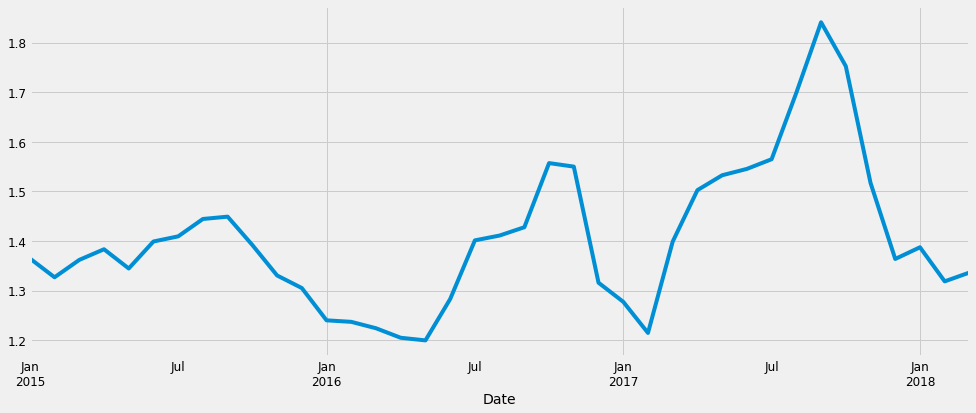

In [87]:
y.plot(figsize=(15,6))
plt.show()

The time series has seasonatily pattern (systematic and calendar related effect): the avocado picking season is between June and October, as seen in each year pick. Also we can decompose the time series into its components: trend, seasonality and noise:

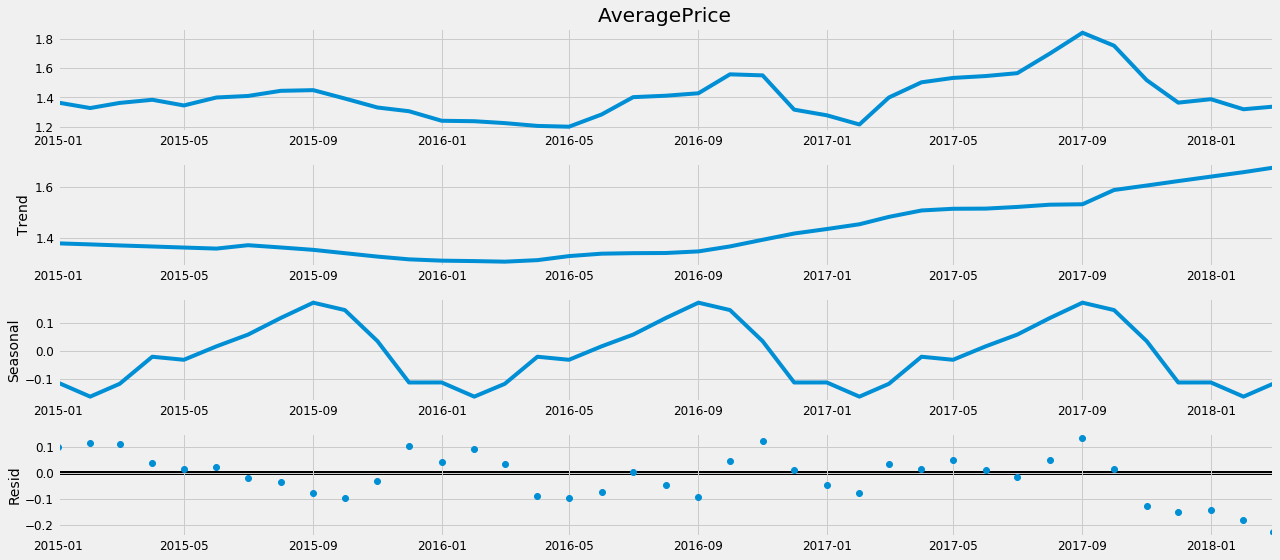

In [88]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', extrapolate_trend = 'freq')
fig = decomposition.plot()
plt.show()

* Level/Observed: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise/Residual: The random variation in the series.

We can see the increasing price since 2016 in the Observed and Trend data. And as observed earlier, the seasonality is also crystal clear.

## Time series forecasting with ARIMA (Autoregressive Integrated Moving Average)

* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

ARIMA models are denoted with the notation ARIMA(p, d, q). 

These three parameters account for seasonality, trend, and noise in data:
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

**p,d,q parameters**

In [89]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


**ARIMA parameter selection**

In [90]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal,results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:136.18157690038117
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1016.7960404216747
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-14.09555437039629
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-2.178406590157259
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-17.322634866608944
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-22.385190029898823
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-3.5927515656567914
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-1.0470475379579023
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:88.52560420303006
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1051.201157307699
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-29.76587925992606
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-10.711196968965048
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-33.11601595663936
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-36.41441349743649
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-16.493082991254326
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-10.939249671861976
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-71.80572351802711
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1096.6

The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.

When comparing two models, the one with the lower AIC is generally “better”.
    
Their low AIC values suggest that these models nicely straddle the requirements of goodness-of-fit and parsimony.

In this case, apparently, the best model is ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-74.35809056177754 . However, I used this model and the forecast gave me a straight line. This happen because the model didn't capture well the trend and it gave no prediction, only plotting the mean.

So to solve this problem, we can try another ARIMA model or just use the pmdarima library to auto-select the best model:

In [112]:
from pmdarima import auto_arima 

auto_arima(y, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  23.435
Date:                              Wed, 25 Mar 2020   AIC                            -40.871
Time:                                      13:29:03   BIC                            -37.096
Sample:                                           0   HQIC                           -39.784
                                               - 39                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0038      0.014      0.262      0.794      -0.025       0.032
ma.S.L12      -0.9609     11.654     -0.082      0.934     -23.802      21.881
sigma2         0.0059      0.068      0.087      0.931      -0.128       0.140
===================================================================================
Ljung-Box (Q):                       30.42   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.21   Prob(JB):                         0.80
Heteroskedasticity (H):               2.57   Skew:                            -0.31
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can see now that the best arima model is (0, 1, 0)x(0, 1, 1, 12)

**ARIMA model fitting**

In [113]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0002   2864.516     -0.000      1.000   -5615.348    5613.347
sigma2         0.0074     21.204      0.000      1.000     -41.552      41.567


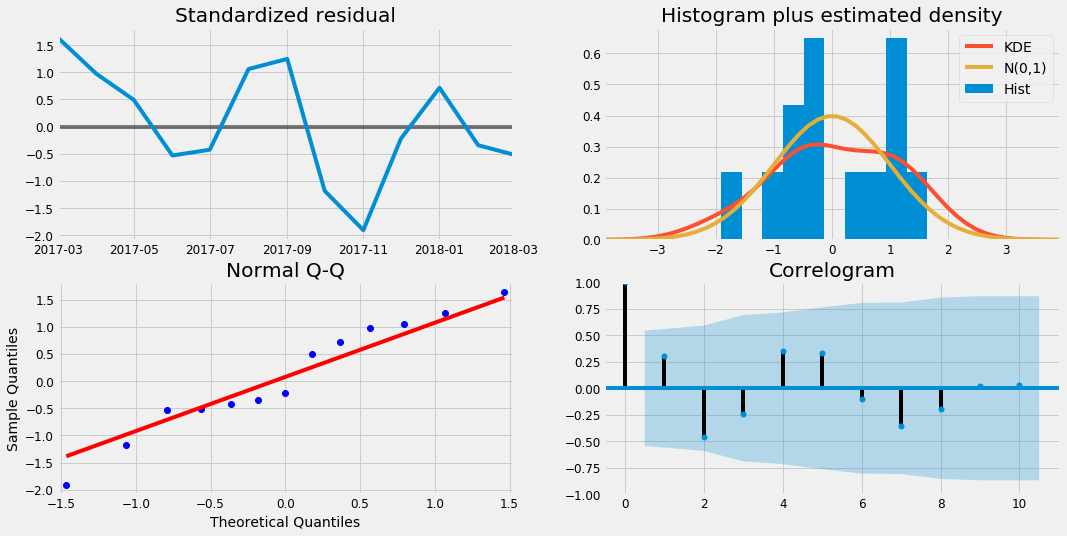

In [114]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

* **Histogram plus estimated density**: the red KDE line follows closely with the N(0,1) line ,where N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed. In this case, the distribution is not completely normal but similar. 

* **Normal Q-Q plot**: shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed. In this case we can see that the residual trend (as in the previous histogram) don't follow completelly a normal distribution.

* **Standardized residual and Correlogram**: it show the residuals over time. It display some seasonality. This is confirmed by the autocorrelation (i.e. correlogram) plot , which shows that the time series residuals have some correlation with lagged versions of itself.

**Validating Forecast**

To ensure the accuracy of our forecast, we can compare predicted and real prices

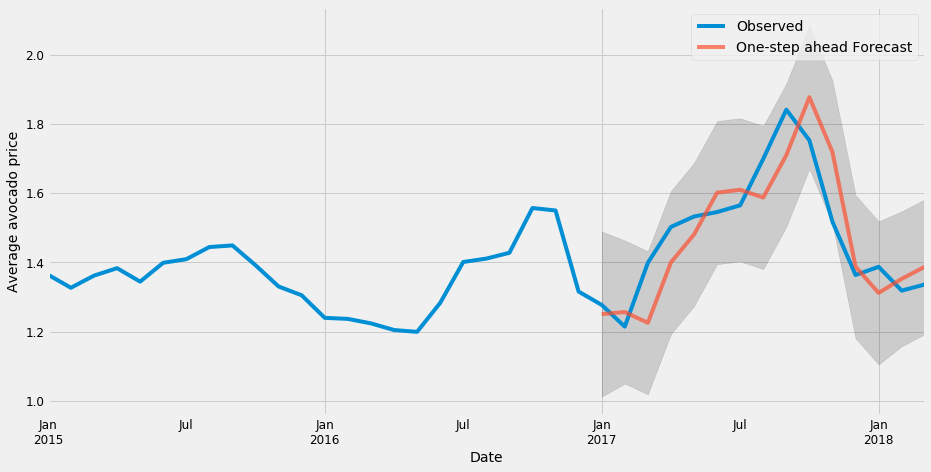

In [119]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.15)
ax.set_xlabel('Date')
ax.set_ylabel('Average avocado price')
plt.legend()
plt.show()

Our forecast show a good alignment with the real values, capturing well the seasonality between June and October. Let's calculate some estimators to validate the forecast:

In [120]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.01


The mean squared error (MSE) of an estimator measures the average of the squares of the errors: the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the better.

In [121]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.1


Root Mean Square Error (RMSE) tells us that our model was able to forecast the average price within 0.1 of the real price, so really good.

**Producing forecast for the next years**

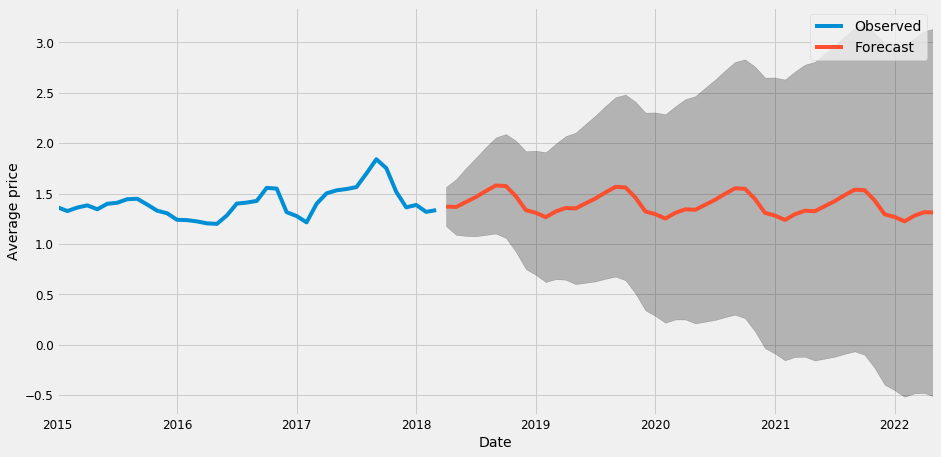

In [122]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Average price')
plt.legend()
plt.show()

It can be seen that our model got the seasonality well although the forecasting lose accuracy the further it moves into the future. 

Finally, it seems that the average price of avocados will decrease a little through the years.